# A notebook to show how to use the full algorithm and return results

Takes as input: Gene set of interest, experimental data, query of interest

Output: causal effect

In [1]:
import pandas as pd
from MScausality.graph_construction.graph import GraphBuilder
import MScausality.data_analysis.normalization as norm

import pickle

import pyro
import pyro.distributions as dist

from pyro.infer.autoguide import AutoNormal
from pyro.infer import SVI, Trace_ELBO, MCMC, NUTS

from pyro.nn import PyroModule
import pyro.poutine as poutine

import torch

import networkx as nx
import y0
from y0.algorithm.simplify_latent import simplify_latent_dag

from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather
from chirho.interventional.handlers import do
from chirho.observational.handlers import condition

from MScausality.causal_model.SCM import LVM, ConditionedProteomicModel, ProteomicPerturbationModel

/Users/kohler.d/opt/anaconda3/envs/MScausality/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


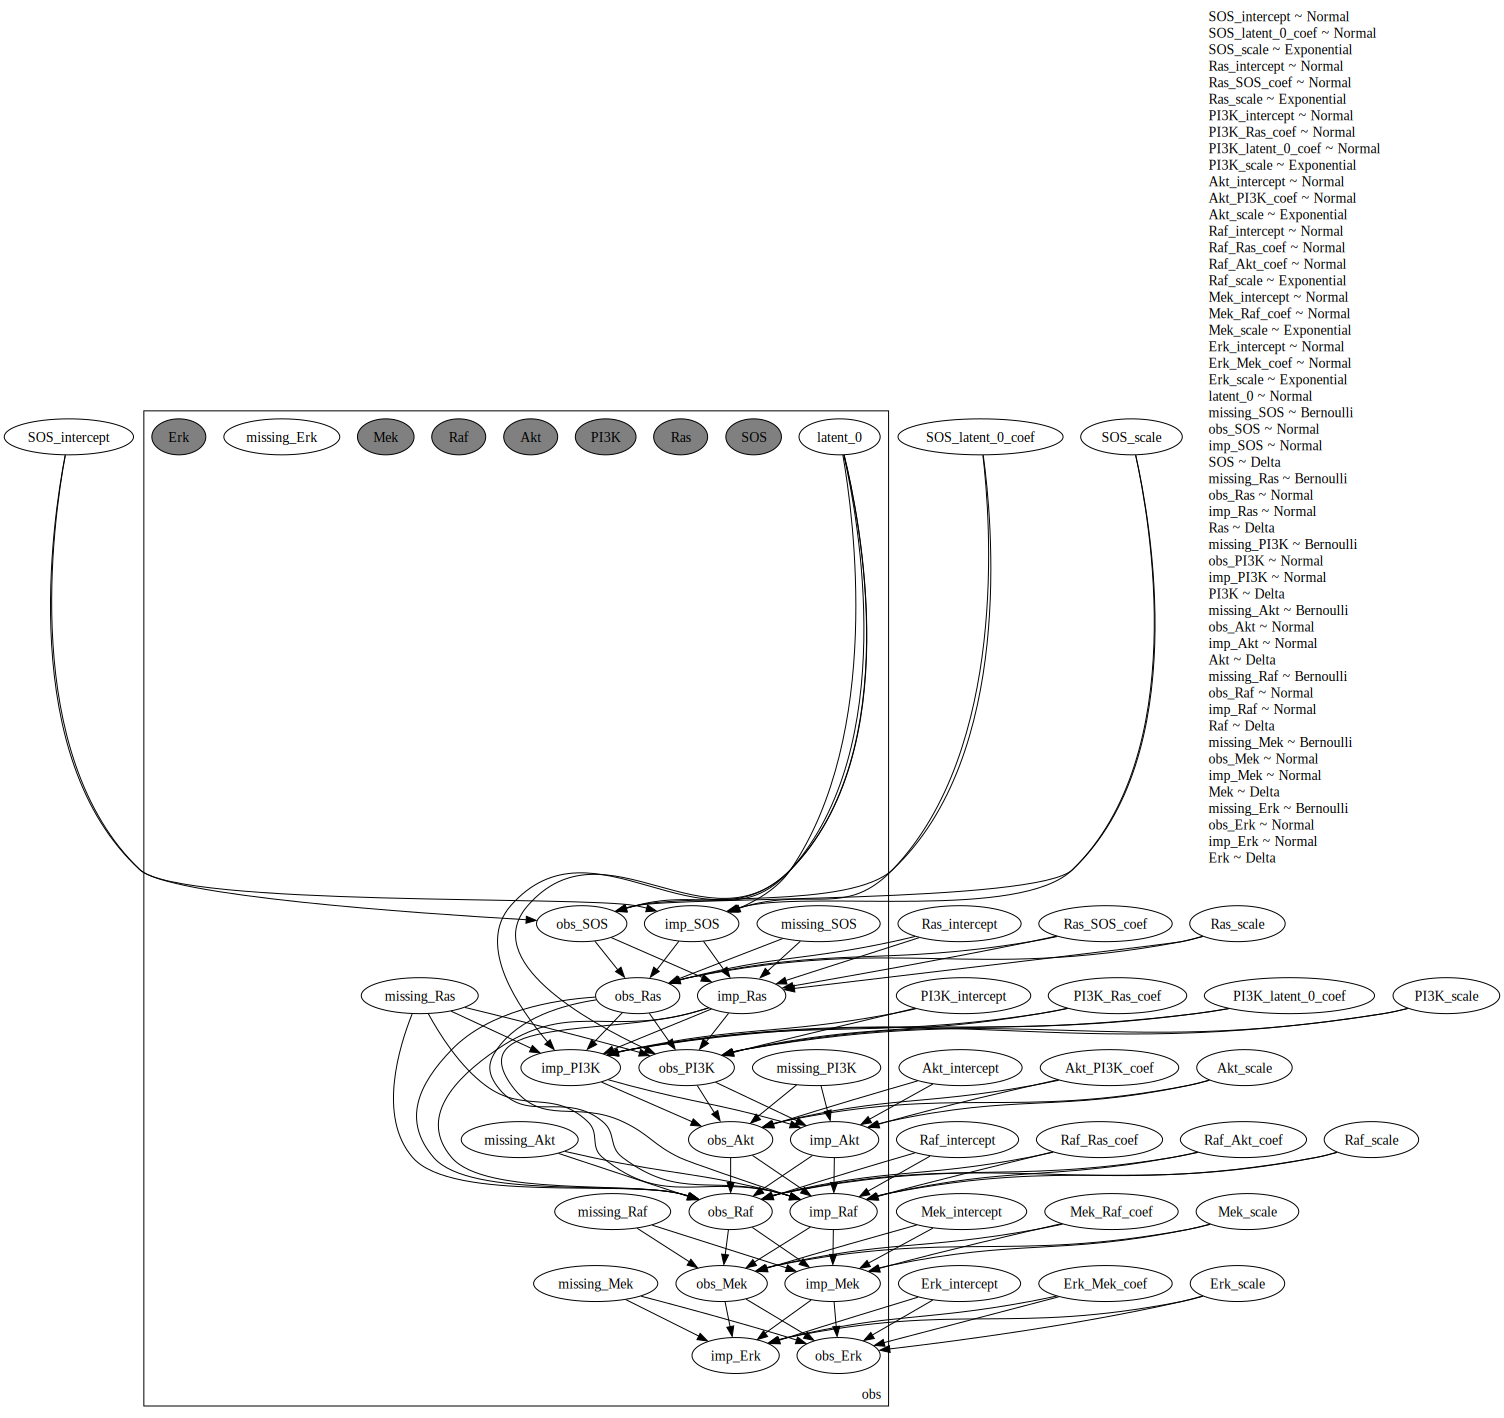

In [2]:
def build_igf_network():
    """
    Create IGF graph in networkx
    
    cell_confounder : bool
        Whether to add in cell type as a confounder
    """
    graph = nx.DiGraph()

    ## Add edges
    graph.add_edge("EGF", "SOS")
    graph.add_edge("EGF", "PI3K")
    graph.add_edge("IGF", "SOS")
    graph.add_edge("IGF", "PI3K")
    graph.add_edge("SOS", "Ras")
    graph.add_edge("Ras", "PI3K")
    graph.add_edge("Ras", "Raf")
    graph.add_edge("PI3K", "Akt")
    graph.add_edge("Akt", "Raf")
    graph.add_edge("Raf", "Mek")
    graph.add_edge("Mek", "Erk")
    
    return graph

def build_admg(graph):
    ## Define obs vs latent nodes
    all_nodes = ["SOS", "PI3K", "Ras", "Raf", "Akt", 
                "Mek", "Erk", "EGF", "IGF"]
    obs_nodes = ["SOS", "PI3K", "Ras", "Raf", "Akt", 
                "Mek", "Erk"]
    latent_nodes = ["EGF", "IGF"]
        
    attrs = {node: (True if node not in obs_nodes and 
                    node != "\\n" else False) for node in all_nodes}

    nx.set_node_attributes(graph, attrs, name="hidden")
    
    ## Use y0 to build ADMG
    simplified_graph = simplify_latent_dag(graph.copy(), "hidden")
    y0_graph = y0.graph.NxMixedGraph()
    y0_graph = y0_graph.from_latent_variable_dag(graph, "hidden")
    
    return y0_graph

graph = build_igf_network()
y0_graph = build_admg(graph)

data = pd.read_csv("../../data/IGF_pathway/high_rep_protein_data.csv")
data = data.drop("originalRUN", axis=1)
data = (data - data.mean()) / data.std()

lvm = LVM(data, y0_graph)
lvm.prepare_graph()
lvm.prepare_data()

model_train = ConditionedProteomicModel(
    ProteomicPerturbationModel(n_obs = len(data), 
    root_nodes = lvm.root_nodes, 
    downstream_nodes = lvm.descendent_nodes)
)

pyro.render_model(ProteomicPerturbationModel(250, lvm.root_nodes, lvm.descendent_nodes), render_distributions=True, render_params=True)